# Machine Learning Classification Model: Predicting Fraudulent Transactions

I built a simple model using the "BankTransactions.xlsx" data set for labeling fraudulent vs non-fraudulent bank transactions. My metric is Class Labels. This project is organized as follows: (1 & 2) data loading and exploration; (3) feature engineering; (4) testing 5 probable algorithms for my dataset; (5) hyper-parameters tuning and running Random Forest algorithm.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Read dataset and display columns
Did some data clieaning prior. Original data set only contained date column, however I created additional date/time collumns allowing me to access individual dates, hours and time.

labels: 1 - fraudulent transaction, 0 - legitimate transaction

In [2]:
data = pd.read_excel("BankTransactions.xlsx")

# assigning 1 value to fraud label and 0 to legit
data['label'] = data['label'].apply(lambda x: 1 if x=='fraud' else 0)

data.head()

,timestamp,date,day,transactionHour,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,label
0,1483228800,2017-01-01T00:00:00Z,2017-01-01,0,00:00:00,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,0
1,1483231743,2017-01-01T00:49:03Z,2017-01-01,0,00:49:03,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,0
2,1483231397,2017-01-01T00:43:17Z,2017-01-01,0,00:43:17,31294145A1,c0ffab1b,94cafc,5735,442,0,81,5.04,9500,0
3,1483229707,2017-01-01T00:15:07Z,2017-01-01,0,00:15:07,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,0
4,1483231029,2017-01-01T00:37:09Z,2017-01-01,0,00:37:09,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,0


# 2. Exploratory Data Analysis


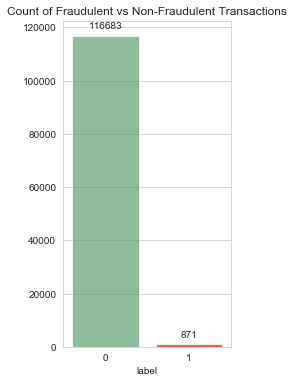

In [3]:
# Plotting class distribution across data set (we see data is highly imbalanced)

distrib = data.groupby(['label'])['label'].count().to_frame()

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(3, 6))
palette = sns.color_palette(["#55a868","r"])

splot = sns.barplot(x=distrib.index, y="label", data=distrib, palette=palette, alpha=0.7)
ax.set_title("Count of Fraudulent vs Non-Fraudulent Transactions")
ax.set_ylabel('')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [4]:
#  Basic stats on transactionAmount 

transAmount = data.groupby(['label'])['transactionAmount'].agg([np.mean, np.min, np.max, np.std]).round().reset_index()
transAmount 

,label,mean,amin,amax,std
0,0,54.0,-0.0,13348.0,184.0
1,1,64.0,-0.0,2434.0,153.0


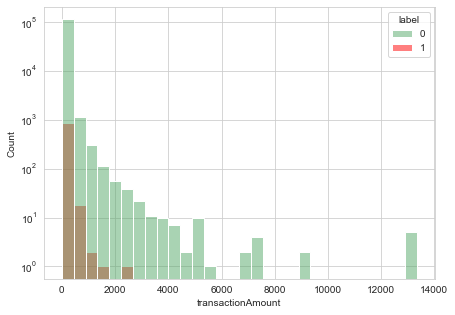

In [5]:
# Plotting the distribution for each class
# Given very few fraudulent transactions, fraudulent occurances better viewed on a logarithmic scale

fig, ax = plt.subplots(figsize=(7, 5))

palette = sns.color_palette(["#55a868","r"])

sns.histplot(data=data, x='transactionAmount', hue="label", bins=30, alpha=0.5, ax = ax, palette=palette)
ax.set_yscale('log')

In [6]:
# splitting data into 2 classes

legit = data.loc[data['label'] == 0]
fraud = data.loc[data['label'] == 1]

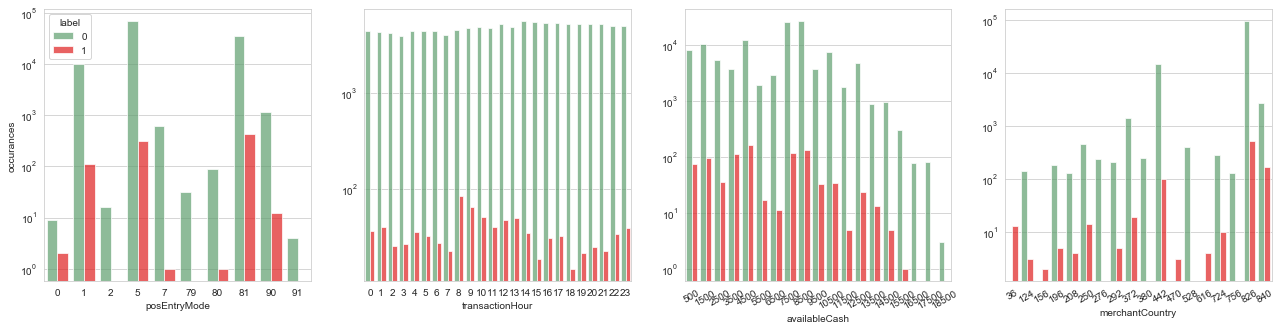

In [7]:
# Plotting the distribution for each class across all numeric features 

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(22, 5))

a = data.groupby(['posEntryMode', 'label'])['posEntryMode'].count().to_frame('occurances').reset_index()
b = data.groupby(['transactionHour', 'label'])['transactionHour'].count().to_frame('occurances').reset_index()
c = data.groupby(['availableCash', 'label'])['availableCash'].count().to_frame('occurances').reset_index()

d = fraud.groupby(['merchantCountry'])['merchantCountry'].count().to_frame('occurances').reset_index()
d = d.nlargest(14, 'occurances')
d["label"] = 1

e = legit.groupby(['merchantCountry'])['merchantCountry'].count().to_frame('occurances').reset_index()
e = e.nlargest(14, 'occurances')
e["label"] = 0

f = d.append(e)

palette = sns.color_palette(["#55a868","r"])
sns.barplot(x='posEntryMode', y='occurances', hue="label", data=a, ax=ax1, palette=palette, alpha=0.7)
sns.barplot(x='transactionHour', y='occurances', hue="label", data=b, ax=ax2, palette=palette, alpha=0.7)
sns.barplot(x='availableCash', y='occurances', hue="label", data=c, ax=ax3, palette=palette, alpha=0.7)
sns.barplot(x='merchantCountry', y='occurances', hue="label", data=f, ax=ax4, palette=palette, alpha=0.7)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')

ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()

plt.setp(ax3.get_xticklabels(), rotation=30);
plt.setp(ax4.get_xticklabels(), rotation=30);

ax2.set_ylabel('');    
ax3.set_ylabel('');
ax4.set_ylabel('');

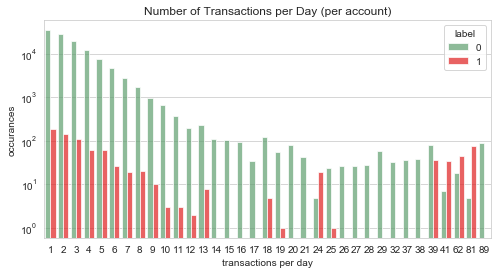

In [8]:
# Calculating number of transactions per day per account and plotting distribution for both clases 

data['transactions per day'] = data.groupby(['day','accountNumber'])['accountNumber'].transform('count')
counts = data.groupby(['transactions per day', 'label'])['transactions per day'].count().to_frame('occurances').reset_index()

fig, ax = plt.subplots(figsize=(8, 4))

palette = sns.color_palette(["#55a868","r"])

ax = sns.barplot(x="transactions per day", y="occurances", hue="label", data=counts, palette=palette, alpha=0.7)

ax.set_yscale('log')

ax.set_title("Number of Transactions per Day (per account)");

# Conclusions

Looking at the features provided and distribution of each class per feature we see no general abnormal fraudulent behaviour/patern apart from the last graph where the number of fraudulent transactions supass legitimate ones for 24 and from 41 to 81 transactins per day 

# 3. Feature Engineering: label encoding

Given the lack of observed general fraudulent behaviour, new features need to be engineered. 
The features can be split into 2 categories:

1) General fraud specific behaviour (many transactions per day for one given account, fraudulent merchants, etc etc)

2) Anomalities in account specific behaviour (unusual shopping hours/transaction method for given marchant, etc etc)

Chosen label encoding due to the nature of the data which is highly categorical

# Features: 1 & 2 

First I decided to get all the mcc, merchantId, countries and accounts where there are no instances of fraud and create feature called 'safe' 

And do the same but for fraudulent transactions. Only certain number of merchantId and 1 mcc had instances of being fraudulent with no legitimate transaction. Since mcc had one instance I decided to not include it, and make a feature for merchantID called 'fraud_merch'

In [9]:
# getting unique values for each class for each feature

mcc_f = fraud['mcc'].unique()
mcc_l = legit['mcc'].unique()

merch_f = fraud['merchantId'].unique()
merch_l = legit['merchantId'].unique()

country_f = fraud['merchantCountry'].unique()
country_l = legit['merchantCountry'].unique()

acc_f = fraud['accountNumber'].unique()
acc_l = legit['accountNumber'].unique()

# function to crosscheck fraudulent vs non-fraudulent lists for each feature 

def unique(x,y):
    unique = [item for item in x if item not in y]
    return unique

# obtaining separate lists of variables for 'only legit' and 'only fraudulent'

mcc_only_l = unique(mcc_l,mcc_f)
# only 1 instnce: excluded 

merch_only_l = unique(merch_l,merch_f)
merch_only_f = unique(merch_f,merch_l)

country_only_l = unique(country_l,country_f)
# no only_fraud countries 

acc_only_l = unique(acc_l,acc_f)
# no only fraudulent accounts

In [10]:
# creating feature 'safe': safe = 1, the rest = 0
data["safe"] = ''
for index, row in data.iterrows():
    if row.loc['mcc'] in mcc_only_l:
        data.at[index, 'safe'] = 1
    elif row.loc['merchantId'] in merch_only_l:
        data.at[index, 'safe'] = 1
    elif row.loc['merchantCountry'] in country_only_l:
        data.at[index, 'safe'] = 1
    elif row.loc['accountNumber'] in acc_only_l:
        data.at[index, 'safe'] = 1
    else:
        data.at[index, 'safe'] = 0

In [11]:
# creating feature 'fraud_merch' = 1, the rest = 0
data["fraud_merch"] = ''
for index, row in data.iterrows():
    if row.loc['merchantId'] in merch_only_f:
        data.at[index, 'fraud_merch'] = 1
    else:
        data.at[index, 'fraud_merch'] = 0  

# Feature 3

Creating feature based on what I observed on the "Number of Transactions per Day (per account)" graph. 
Creating 'many' feature and labeling (1) all transactions that were part of either 24 or 39 or 41 or 62 or 81 transactions per day. The rest of the transactions are labeled 0 

In [12]:
data['many'] = np.where((data['transactions per day'] == 24) | (data['transactions per day'] == 39) | (data['transactions per day'] == 41) | (data['transactions per day'] == 62) | (data['transactions per day'] == 81), 1, 0)

# Feature 4 

Features from 4 to 16 are based on individual account behaviour.

Feature 4 is based on whether transactionAmount is above the maximum amount normally spent in the particular shop for any given account 

In [13]:
# asigning 1 if transactionAmount is > than max transaction amount for individual merchant for each account
above_max_trans = legit.groupby(['accountNumber', 'merchantId'])['transactionAmount'].max().round(2).to_frame('above_max_trans').reset_index()
data = data.merge(above_max_trans, on=['accountNumber', 'merchantId'], how='left')
data['above_max_trans'] = data['above_max_trans'].fillna(0)
data['above_max_trans'] = np.where((data['above_max_trans'] < data['transactionAmount']),1,0)

# Feature: 5 to 16

Looking into account specific behaviouurs such as: merchants with certain ZIP codes or paying methods, shopping hours countries where fraud tend to occur for each individual account. And the same logic applied to legitimite transactions. 

In [14]:
# fraudulent merchants 

fraud_merch = legit.groupby(['accountNumber', 'merchantId'])['merchantId'].count().to_frame('merch_fraud').reset_index()
data = data.merge(fraud_merch, on=['accountNumber', 'merchantId'], how='left')

In [15]:
# legitimate merchants 

leg_merch = fraud.groupby(['accountNumber', 'merchantId'])['merchantId'].count().to_frame('merch_leg').reset_index()
data = data.merge(leg_merch, on=['accountNumber', 'merchantId'], how='left')

In [16]:
# fraud occuring with certain merchants and ZIP codes

fraud_zip = legit.groupby(['accountNumber', 'merchantId', 'merchantZip'])['merchantZip'].count().to_frame('zip_fraud').reset_index()
data = data.merge(fraud_zip, on=['accountNumber', 'merchantId', 'merchantZip'], how='left')

In [17]:
# legitimate transactions with certain merchants and ZIP codes

leg_zip = fraud.groupby(['accountNumber', 'merchantId', 'merchantZip'])['merchantZip'].count().to_frame('zip_leg').reset_index()
data = data.merge(leg_zip, on=['accountNumber', 'merchantId', 'merchantZip'], how='left')

In [18]:
# fraud occuring with certain merchants and paying methods 

fraud_pEM = legit.groupby(['accountNumber', 'merchantId', 'posEntryMode'])['posEntryMode'].count().to_frame('pEM_fraud').reset_index()
data = data.merge(fraud_pEM, on=['accountNumber', 'merchantId','posEntryMode'], how='left')

In [19]:
# legitimate pransactions with certain merchants and paying methods 

leg_pEM = fraud.groupby(['accountNumber', 'merchantId', 'posEntryMode'])['posEntryMode'].count().to_frame('pEM_leg').reset_index()
data = data.merge(leg_pEM, on=['accountNumber', 'merchantId','posEntryMode'], how='left')

In [20]:
# fraud occuring with certain merchants and and in certain countries

fraud_country = legit.groupby(['accountNumber', 'merchantId', 'merchantCountry'])['merchantCountry'].count().to_frame('country_fraud').reset_index()
data = data.merge(fraud_country, on=['accountNumber', 'merchantId','merchantCountry'], how='left')

In [21]:
# legitimate pransactions with certain merchants and and in certain countries

leg_country = fraud.groupby(['accountNumber', 'merchantId', 'merchantCountry'])['merchantCountry'].count().to_frame('country_leg').reset_index()
data = data.merge(leg_country, on=['accountNumber', 'merchantId', 'merchantCountry'], how='left')

In [22]:
# fraud occuring with certain mcc 

fraud_mcc = legit.groupby(['accountNumber', 'mcc'])['mcc'].count().to_frame('mcc_fraud').reset_index()
data = data.merge(fraud_mcc, on=['accountNumber', 'mcc'], how='left')

In [23]:
# legitimate pransactions with certain mcc

leg_mcc = fraud.groupby(['accountNumber', 'mcc'])['mcc'].count().to_frame('mcc_leg').reset_index()
data = data.merge(leg_mcc, on=['accountNumber', 'mcc'], how='left')

In [24]:
# fraud occuring with certain merchants at certain hours

fraud_hour = legit.groupby(['accountNumber', 'merchantId', 'transactionHour'])['transactionHour'].count().to_frame('hour_fraud').reset_index()
data = data.merge(fraud_hour, on=['accountNumber', 'merchantId', 'transactionHour'], how='left')

In [25]:
# legitimate pransactions with certain merchants at certain hours

leg_hour = fraud.groupby(['accountNumber', 'merchantId', 'transactionHour'])['transactionHour'].count().to_frame('hour_leg').reset_index()
data = data.merge(leg_hour, on=['accountNumber', 'merchantId', 'transactionHour'], how='left')

# Label-encoding features (5 to 16)

After merging dataframes:
Where value = Nan assign 1, values with numbers assing 0 
In this way I label account unique behaviour.

In [26]:
data[['merch_fraud', 'merch_leg', 'zip_fraud', 'zip_leg', 'pEM_fraud', 'pEM_leg', 'country_fraud', 'country_leg', 'mcc_fraud', 'mcc_leg', 'hour_fraud', 'hour_leg']] = np.where((data[['merch_fraud', 'merch_leg', 'zip_fraud', 'zip_leg', 'pEM_fraud', 'pEM_leg', 'country_fraud', 'country_leg', 'mcc_fraud', 'mcc_leg', 'hour_fraud', 'hour_leg']].isnull()), 1, 0)

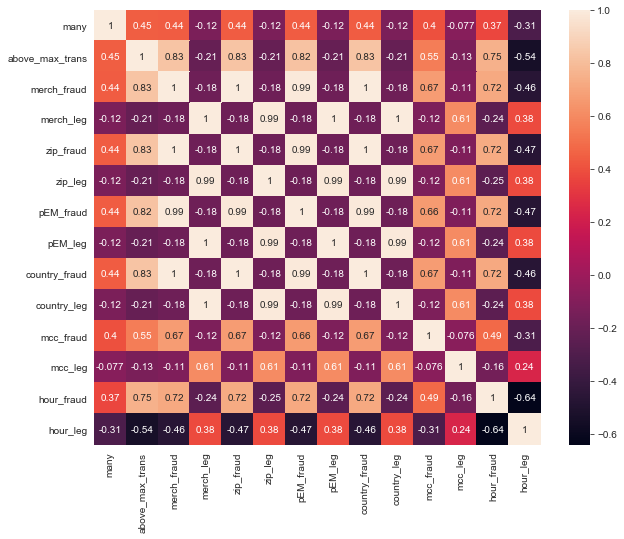

In [27]:
# Examining correlation among features

df = data[['safe','fraud_merch','many','above_max_trans','merch_fraud', 'merch_leg', 'zip_fraud', 'zip_leg', 'pEM_fraud', 'pEM_leg', 'country_fraud', 'country_leg', 'mcc_fraud', 'mcc_leg', 'hour_fraud', 'hour_leg']]

corrMatrix = df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrMatrix, annot=True)
plt.show()

# 4. Testing models

Spot checking some of the machine learning algorithms to get a better idea of which algorithm would perform best on my data. I will evaluate candidate models using repeated stratified k-fold cross-validation. Stratified means that each fold will contain the same mixture of examples by class, that is about 99.2 percent to 0.8 percent normal and fraudulent transaction respectively. I will use the recommended metric of area under precision-recall curve or PR AUC.

1) DecisionTreeClassifier - The decision tree splits the nodes on all available variables and then selects the split which results in most homogeneous sub-nodes.

2) KNeighborsClassifier - It makes its selection based off of the proximity to other data points regardless of what feature the numerical values represent.

3) BaggingClassifier - is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction

4) RandomForestClassifier - The fundamental difference between bagging and random forest is that in Random forests, only a subset of features are selected at random out of the total and the best split feature from the subset is used to split each node in a tree, unlike in bagging where all features are considered for splitting a node

5) ExtraTreesClassifier - like Random Forest, in that it builds multiple trees and splits nodes using random subsets of features, but with two key differences: it does not bootstrap observations (meaning it samples without replacement), and nodes are split on random splits, not best splits

In [28]:
X = data[['safe','fraud_merch','many','above_max_trans','merch_fraud','merch_leg',
          'zip_fraud','zip_leg','pEM_fraud','pEM_leg','country_fraud',
          'country_leg','mcc_fraud','mcc_leg','hour_fraud','hour_leg']]

y = data['label']

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc
from numpy import mean
from numpy import std

# calculating precision-recall area under curve
def pr_auc(y_true, probas_pred):
    p, r, _ = precision_recall_curve(y_true, probas_pred)
    return auc(r, p)


# evaluating a model
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    metric = make_scorer(pr_auc, needs_proba=True)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# model of reference
# Using DummyClassifier a model that predicts the positive class (class 1) for all examples will provide a baseline performance when using the precision-recall area under curve metric.
model = DummyClassifier(strategy='constant', constant=1)

#evaluating the model
scores = evaluate_model(X, y, model)
# summarizing performance
print('Mean PR AUC: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean PR AUC: 0.504 (0.000)


In [ ]:
# Classifier Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

#  evaluating several models (hyperparameters not tuned yet)
def get_models():
    models, names = list(), list()
    # CART
    models.append(DecisionTreeClassifier())
    names.append('CART')
    # KNN
    steps = [('s',StandardScaler()),('m',KNeighborsClassifier())]
    models.append(Pipeline(steps=steps))
    names.append('KNN')
    # Bagging
    models.append(BaggingClassifier(n_estimators=100))
    names.append('BAG')
    # RF
    models.append(RandomForestClassifier(n_estimators=100))
    names.append('RF')
    # ET
    models.append(ExtraTreesClassifier(n_estimators=100))
    names.append('ET')
    return models, names

# defining models
models, names = get_models()
results = list()
# evaluating each model
for i in range(len(models)):
    # evaluating the model and storing results
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    # summarizing performance
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.show()

>CART 0.956 (0.009)


# 5. Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# testing different parameters 

param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 80, 90],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [10, 12, 14],
    'n_estimators': [50, 70, 100]
}
# Creating a base model
clf = RandomForestClassifier()
# Instantiating the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
grid_search.fit(X_train,y_train)
grid_search.best_params_

In [32]:
X = data[['safe','fraud_merch','many','above_max_trans','merch_fraud','merch_leg',
          'zip_fraud','zip_leg','pEM_fraud','pEM_leg','country_fraud',
          'country_leg','mcc_fraud','mcc_leg','hour_fraud','hour_leg']]

y = data['label']

In [33]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

#  evaluating several sampling startegies: sampling method SMOTE 
def get_models():
    models, names = list(), list()
# st of 0.008 represents my original dataset minority class distribution
    models.append(SMOTE(sampling_strategy=0.008))
    names.append('Without SMOTE')
   
    models.append(SMOTE(sampling_strategy=0.02))
    names.append('SMOTE st =0.01')
    
    models.append(SMOTE(sampling_strategy=0.05))
    names.append('SMOTE st =0.05')
    
    models.append(SMOTE(sampling_strategy=0.2))
    names.append('SMOTE st =0.1')
    
    return models, names

In [34]:
# splitting data into train and test subsets
# runninf RF with preselected hyperparameters
features = list()
con_matr = list()

def evaluate_SMOTE(X, y, model):
    X, y = model.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    rfc1=RandomForestClassifier(class_weight='balanced_subsample', max_features=3, n_estimators= 50, max_depth=80, min_samples_split=14, min_samples_leaf=2)
    pred = rfc1.fit(X_train, y_train).predict(X_test)
    feature_imp = pd.Series(rfc1.feature_importances_,index=X.columns).sort_values(ascending=False)
    scores = f1_score(y_test, pred, average=None)
    con_matr.append(y_test)
    con_matr.append(pred)
    features.append(feature_imp)
    return scores

In [35]:
# getting F1 scores for label: 0 and 1 for each sampling method 
models, names = get_models()
results = list()

for i in range(len(models)):
    scores = evaluate_SMOTE(X, y, models[i])
    results.append(scores)

for i in range(len(results)):
    print ('>%s L:0 %.2f L:1 %.2f'% (names[i], results[i][0], results[i][1]));

>Without SMOTE L:0 1.00 L:1 0.77
>SMOTE st =0.01 L:0 1.00 L:1 0.89
>SMOTE st =0.05 L:0 1.00 L:1 0.96
>SMOTE st =0.1 L:0 1.00 L:1 0.99


In [36]:
# getting results into dataframe for plotting

df2 = {'Sampling': ['Without SMOTE','Without SMOTE','SMOTE st =0.02','SMOTE st =0.02','SMOTE st =0.05','SMOTE st =0.05','SMOTE st =0.1','SMOTE st =0.1'],
       'F1 Score': [results[0][0], results[0][1], results[1][0], results[1][1], results[2][0], results[2][1], results[3][0], results[3][1]],'label': [0,1,0,1,0,1,0,1]}
df2 = pd.DataFrame(data=df2)

# Results

1) F1 score for label 0 and label 1: algorithm performace for each sampling method

2) Confusion matrix for each sampling method 

3) Classification reports for each sampling strategy

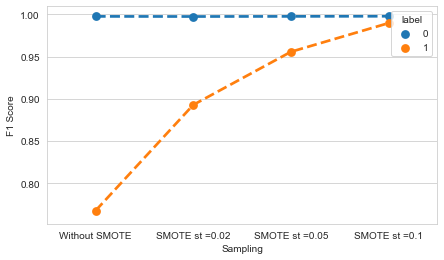

In [38]:
# 1)
plt.subplots(figsize=(7, 4))
sns.pointplot(data=df2, x="Sampling", y="F1 Score", hue="label",linestyles=["--", "--"]);

In [42]:
# getting all y_test and pred for each sampling method 
y_test_without_SMOTE = con_matr[0]
pred_without_SMOTE = con_matr[1]
y_test_02 = con_matr[2]
pred_test_02 = con_matr[3]
y_test_05 = con_matr[4]
pred_test_05 = con_matr[5]
y_test_1 = con_matr[6]
pred_test_1 = con_matr[7]

In [43]:
# 2) 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# plotting confusion matrix for each sampling method
def con_mat(y_test,pred):
    df = pd.DataFrame(
        {'y_Actual': y_test,
         'y_Predicted': pred,
        })

    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    return confusion_matrix


# classification report for each sampling method
def report(pred, y_test):
    return print(classification_report(pred, y_test, target_names = ['0', '1']))

In [44]:
df_without = con_mat(y_test_without_SMOTE,pred_without_SMOTE)
df_02 = con_mat(y_test_02,pred_test_02)
df_05 = con_mat(y_test_05,pred_test_05)
df_1 = con_mat(y_test_1,pred_test_1)

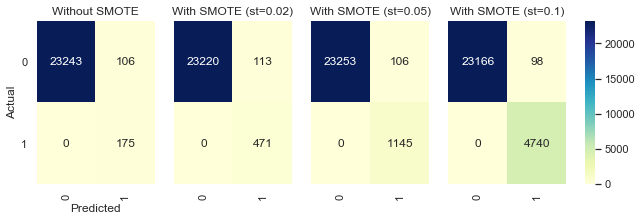

In [45]:
sns.set(rc={'figure.figsize':(10,3)})
f,(ax1,ax2,ax3,ax4, axcb) = plt.subplots(1,5, 
            gridspec_kw={'width_ratios':[1,1,1,1,0.08]})
ax1.get_shared_y_axes().join(ax2,ax3,ax4)
g1 = sns.heatmap(df_without,cmap="YlGnBu", annot=True, fmt='g', cbar=False,ax=ax1)
g1.set_ylabel('Actual')
g1.set_xlabel('Predicted')
g1.set_title('Without SMOTE')
g2 = sns.heatmap(df_02,cmap="YlGnBu", annot=True, fmt='g', cbar=False,ax=ax2)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
g2.set_title('With SMOTE (st=0.02)')
g3 = sns.heatmap(df_05,cmap="YlGnBu", annot=True, fmt='g', cbar=False,ax=ax3)
g3.set_ylabel('')
g3.set_xlabel('')
g3.set_yticks([])
g3.set_title('With SMOTE (st=0.05)')
g4 = sns.heatmap(df_1,cmap="YlGnBu", annot=True, fmt='g', ax=ax4, cbar_ax=axcb)
g4.set_ylabel('')
g4.set_xlabel('')
g4.set_yticks([])
g4.set_title('With SMOTE (st=0.1)')


for ax in [g1,g2,g3,g4]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.show()

In [46]:
# 3)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def report(pred, y_test):
    return print(classification_report(pred, y_test, target_names = ['0', '1']))
    

In [47]:
# without SMOTE
report(pred_without_SMOTE, y_test_without_SMOTE)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23243
           1       1.00      0.62      0.77       281

    accuracy                           1.00     23524
   macro avg       1.00      0.81      0.88     23524
weighted avg       1.00      1.00      0.99     23524



In [48]:
# with SMOTE st = .02
report(pred_test_02, y_test_02)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23220
           1       1.00      0.81      0.89       584

    accuracy                           1.00     23804
   macro avg       1.00      0.90      0.95     23804
weighted avg       1.00      1.00      1.00     23804



In [49]:
# with SMOTE st = .05
report(pred_test_05, y_test_05)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23253
           1       1.00      0.92      0.96      1251

    accuracy                           1.00     24504
   macro avg       1.00      0.96      0.98     24504
weighted avg       1.00      1.00      1.00     24504



In [50]:
# with SMOTE st = .1
report(pred_test_1, y_test_1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23166
           1       1.00      0.98      0.99      4838

    accuracy                           1.00     28004
   macro avg       1.00      0.99      0.99     28004
weighted avg       1.00      1.00      1.00     28004



# Feature importance

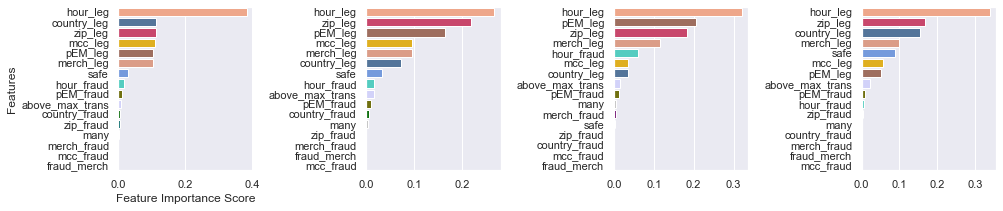

In [51]:
# from evaluate_SMOTE() feature_imp score obtained values for each sampling method 
# visualising important features
s_without = features[0]
s_02 = features[1]
s_05 = features[2]
s_1 = features[3]  

sns.set(rc={'figure.figsize':(14,3)})

colors = {'hour_leg':'#FFA07A', 'country_leg':'#4974a5', 'pEM_leg':'#A86855', 'merch_leg':'#E9967A',
          'zip_leg':'#DE3163', 'mcc_leg':'#FFBF00', 'safe':'#6495ED', 'hour_fraud':'#40E0D0',
          'above_max_trans':'#CCCCFF', 'pEM_fraud':'#808000', 'zip_fraud':'#008080', 'merch_fraud':'#800080',
          'many':'#C0C0C0', 'fraud_merch':'#FF7F50', 'country_fraud':'green', 'mcc_fraud':'black'}

f, (ax1,ax2,ax3, ax4) = plt.subplots(1, 4)
ax1 = sns.barplot(x=s_without, y=s_without.index, ax=ax1, palette=colors)
ax2 = sns.barplot(x=s_02, y=s_02.index, ax=ax2, palette=colors)
ax3 = sns.barplot(x=s_05, y=s_05.index, ax=ax3, palette=colors)
ax4 = sns.barplot(x=s_1,  y=s_1.index, ax=ax4, palette=colors)

ax1.set_ylabel('Features')
ax1.set_xlabel('Feature Importance Score')
f.tight_layout(pad=.8)

# Result Discusion

It seems that my model succesfully cought all fraudulent transactions (confusion matrix) even without oversampling minority class. As the minority class gets oversampled at 2%, 5% and 10% of total transactions, the F1 score gradually increases. However the actual number of false positives stays relatively the same, so the increase in F1 is purely due to the increase of correctly labeled fraudulent transactions lowering the ration of false positives. Therefore, after deeper analysis of false positive composition I have noticed that majority of those had 0 labels in all the features, making it difficult for the algorithm to classify them. In order to improve the model, next steps would be to look for any other features helping to catch all transactions.

However, the most important aspect is to capture and corectly label fraudulent transactions as misslabeling them can be pricey, especially in real life scenarios

In [468]:
#false_positives = np.logical_and(y_test != pred, pred == 1)
#FP = X_test[false_positives]

In [307]:
#true_positives = np.logical_and(y_test == y_test, y_test != 0)
#TP = X_test[true_positives]

In [259]:
#true_negatives = np.logical_and(y_test == y_test, y_test != 1)
#TN = X_test[true_negatives]